# Preprocess

#### Data Cleaning Steps
* remove number with a sign : , ( ) - + 
* may deal with wrong spelling words
* remove stopwords

# Process
#### Steps
* Clustering 
* Topic modeling
* Subcluster

In [40]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import pythainlp
from pythainlp import word_tokenize, Tokenizer
from pythainlp.corpus.common import thai_stopwords
from pythainlp.ulmfit import document_vector
import re

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [42]:
data = pd.read_excel('Abstract.xlsx')
print(data.columns)

Index(['ชื่อเรื่องไทย', 'ชื่อเรื่องอังกฤษ', 'คำสำคัญไทย', 'คำสำคัญอังกฤษ',
       'บทคัดย่อ', 'Abstract'],
      dtype='object')


In [43]:
titles = []
for i in range(0,9):
    sub = data.at[i,'ชื่อเรื่องไทย']
    titles.append(sub)
print(titles)

['การเพาะเลี้ยงอับละอองเรณูเพื่อสร้างประชากรในการจัดทำแผนที่พันธุกรรมและการสร้างสายพันธุ์แท้ ', 'การพัฒนาเทคโนโลยีการจัดการศัตรูข้าวแบบผสมผสานในนาชลประทานภาคใต้ ', 'การตรวจสอบความหลากหลายของพันธุ์ข้าวด้วยเครื่องหมายโมเลกุล ', 'การศึกษาผลกระทบจากการทำลายของศัตรูข้าวหลายชนิดในสภาพภูมิอากาศและการเขตกรรมที่ต่างกันในนิเวศนาชลประทาน ', 'ผลของการเปลี่ยนแปลงสภาพภูมิอากาศต่อชนิดของเชื้อสาเหตุและการระบาดของโรคข้าวในนาชลประทานที่ปลูกต่อเนื่อง ', 'การจัดการเทคโนโลยีการผลิตที่เหมาะสมเพื่อการลดต้นทุนการผลิตข้าวในเขตนาชลประทาน ', 'การวิจัยและพัฒนาเทคโนโลยีการผลิตพันธุ์ข้าวสาลีอินทรีย์ ', 'การวิจัยและพัฒนาการป้องกันกำจัดข้าววัชพืชในที่ราบลุ่มภาคกลางและภาคเหนือตอนล่าง ', 'การพัฒนาการผลิตข้าวไร่ในพื้นที่สวนยางพาราและปาล์มน้ำมันภาคใต้ฝั่งตะวันตก ']


In [50]:
abstract = []
for i in range(0,29):
    sub = data.at[i,'บทคัดย่อ']
    abstract.append(sub)
# print(abstract)

In [51]:
def remove(text):
    text = text.replace("-",'')
    return re.sub(r"[\n|\t|\d|%|(|)|,|.|/|ฯ]{1,}", "", text)

rm_abstract = []
for i in range(0,len(abstract)):
    sub = remove(abstract[i])
    rm_abstract.append(sub)
# print(rm_abstract)

In [52]:
token_abstract = []
for i in range(0,len(abstract)):
    sub = word_tokenize(rm_abstract[i], engine="deepcut", keep_whitespace=False)
#     word = 0
#     while word <= len(sub):
#         if sub[word] in thai_stopwords():
#             del sub[word]
    token_abstract.append(sub)
# print(token_abstract)

In [53]:
sw_abstract = []
rm_sw = ''
for doc in token_abstract:
    for word in doc:
        if word not in thai_stopwords():
            rm_sw += word+' '
    sw_abstract.append(rm_sw)
    rm_sw = ''
# print(sw_abstract)

### Extracting Keywords

reference form : https://www.kaggle.com/jbencina/clustering-documents-with-tfidf-and-kmeans

In [54]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000
)
tfidf.fit(sw_abstract)
text = tfidf.transform(sw_abstract)

### Finding Optimal Clusters

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


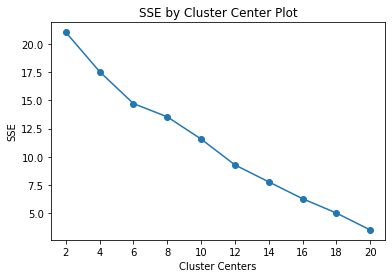

In [57]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(text, 20)

In [59]:
clusters = MiniBatchKMeans(n_clusters=12, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)

### Plotting Clusters

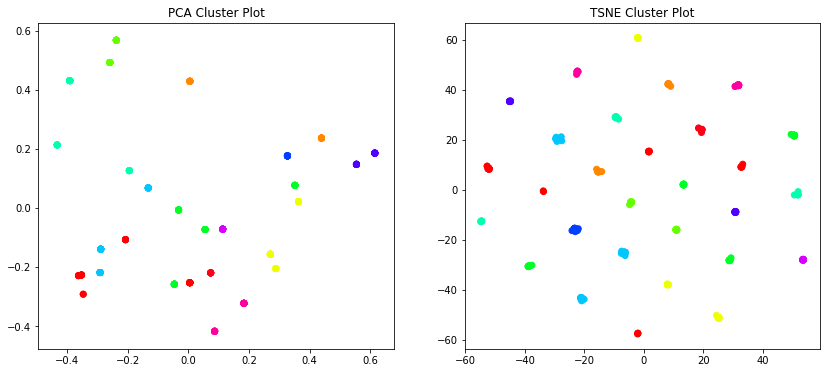

In [60]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=True)
    
    pca = PCA(n_components=2).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(PCA(n_components=5).fit_transform(data[max_items,:].todense()))
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

### Top Keywords

In [61]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
เก,สาย,อย,ผล,เกษตรกร,ดำ,ยว,นา,เมล,นธ

Cluster 1
แปลง,กกไร,ไนโตรเจน,นธ,ใบ,อากาศ,เส,ตรา,โรค,ไหม

Cluster 2
นต,เคม,เช,ทธ,ทดลอง,ภาพ,ประส,กำจ,สาร,ชพ

Cluster 3
ทดลอง,แตกต,ดอก,ใบ,นธ,แสง,กกไร,ตรา,ไนโตรเจน,ใส

Cluster 4
แปลง,ลด,ระบบ,งหว,อง,นท,ตร,ใบ,เกษตรกร,ผล

Cluster 5
กกไร,ไร,ไนโตรเจน,ผล,โลกร,ใส,าง,สร,นธ,สาย

Cluster 6
ปร,อน,กษณะ,เกษตรกร,ทดลอง,ดอก,ไร,ปล,ตรวจสอบ,นธ

Cluster 7
ยง,ประโยชน,จำนวน,าง,ไหม,โรค,แบ,วอย,ตรวจสอบ,เช

Cluster 8
โรค,กษา,ระบาด,อเน,เช,ตร,สภาพ,ชน,อากาศ,นาชลประทาน

Cluster 9
เปร,ทดลอง,ดำเน,ดำ,กรรมว,กกไร,ระบบ,ปล,าน,หว

Cluster 10
ณหภ,เก,สาร,ปร,มาณ,บร,กษา,อน,อง,กล

Cluster 11
อากาศ,เส,นาปร,อม,ฤด,อน,ปล,หม,รวง,ณหภ
